In [43]:
%logstop
%logstart -rtq ~/.logs/ML_ModelSelection.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets
from ipywidgets import interact

# Model selection
<!-- requirement: images/ml_map.png -->

We have defined machine learning as the process of optimizing the cost function by tweaking the parameters of a model. We have defined a model as some map that uniquely maps input (features) to output (labels or target values). We've left this definition very vague, because there are many popular models used for machine learning. In this notebook we'll explore a few of them and investigate how to choose between different possible models.

In [4]:
!wget http://dataincubator-wqu.s3.amazonaws.com/caldata/cal_housing.pkz -nc -P ~/scikit_learn_data/

File ‘/home/jovyan/scikit_learn_data/cal_housing.pkz’ already there; not retrieving.



In [5]:
from sklearn.datasets import fetch_california_housing

cali_data = fetch_california_housing()

cali_df = pd.DataFrame(cali_data.data, columns=cali_data.feature_names)
cali_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We'll again work with the California data set, predicting home values based on the features. While this is a regression task, the concepts involved in model selection also apply to classification tasks, and many models are capable of both regression and classification.

## Exploratory analysis

Model selection begins with characterizing our data: how many features are there, how many observations, are any features correlated, are the relationships between features and labels linear or nonlinear, is the variance in the features uniform, etc.? The `scikit-learn` documentation includes a [flowchart](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) illustrating just some possible models and factors we might consider while we're exploring our data set.

![ml_model_flowchart](images/ml_map.png)

We'll dive deeper into some of these considerations in future lessons. First let's visualize our data.

In [6]:
def plot_feature(feature):
    plt.plot(cali_df[feature], cali_data.target, '.')
    plt.xlabel(feature)
    plt.ylabel('Median home value')

menu = cali_data.feature_names

interact(plot_feature, feature=menu);

interactive(children=(Dropdown(description='feature', options=('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', …

The relationship between home value and some of the features looks very linear (e.g. median income), but others look non-linear or random (e.g. house age or geography). We've discussed [linear regression](ML_LinearRegression.ipynb) -- let's try modeling one of the non-linear features.

## Decision Trees

Encapsulate nonlinear behaviour of target vs certain features.

A decision tree is essentially a logic tree that branches based on feature values.

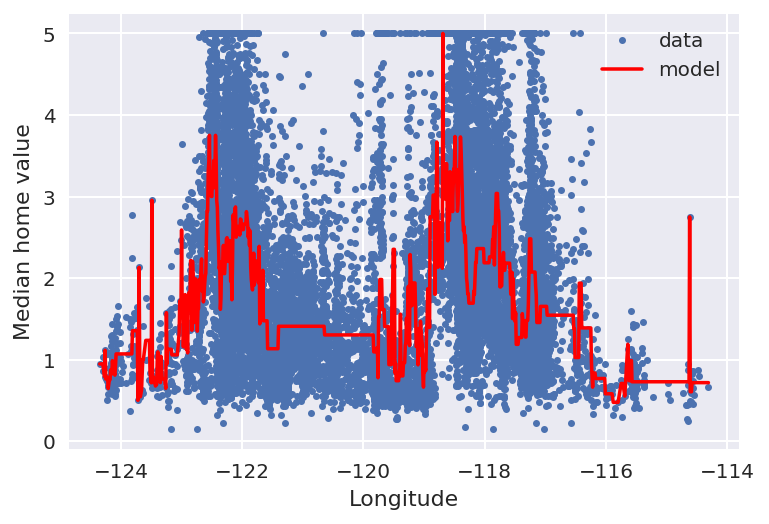

In [7]:
from sklearn import tree
from IPython import display
from graphviz import Source

model = tree.DecisionTreeRegressor(max_depth=10) # can change max depth to get 2^m bins - many bins = overfit!
model.fit(cali_df['Longitude'].to_frame(), cali_data.target)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), 
         model.predict(cali_df['Longitude'].sort_values().to_frame()), 
         'r-', label='model')

plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.legend()

# graph = Source(tree.export_graphviz(model, out_file=None, feature_names=['Longitude']))
# display.SVG(graph.pipe(format='svg'))

## By allowing for more branching, we can make our model more complex. Does this make our model better or worse?

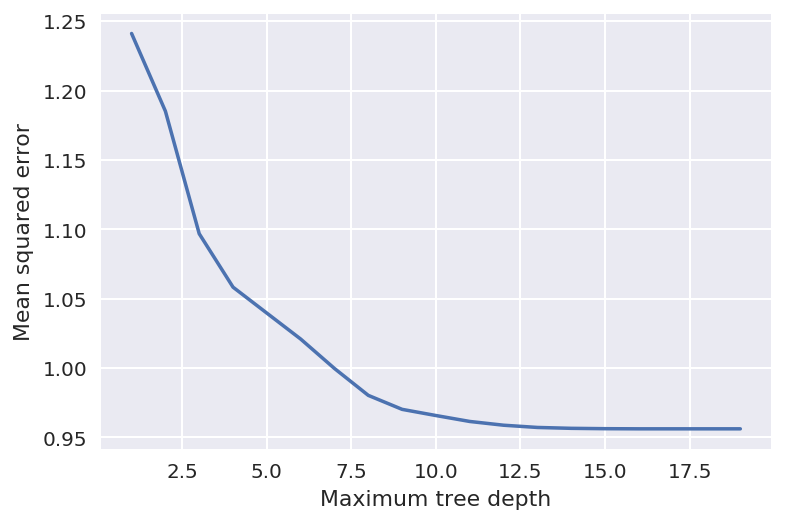

In [8]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 20)
training_error = []
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(cali_df['Latitude'].to_frame(), cali_data.target)
    training_error.append(mse(cali_data.target, model.predict(cali_df['Latitude'].to_frame())))

plt.plot(max_depths, training_error)
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean squared error');

We reach a conflict: the model looks qualitatively worse beyond `max_depth > 5` but the error keeps dropping. This problem is called _overfitting_. The model looks worse because it doesn't follow the trend of the data, but instead follows the random noise. To detect overfitting, we need to see how our model generalizes to new data. We can do this artificially by withholding part of our data set during the training step, and then using it to test the model.

Use test set to estimate generalised error!

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df['Longitude'].to_frame(), 
                                                             cali_data.target), test_size=0.1, random_state=0)

print(X_train.shape)
print(X_test.shape)

(18576, 1)
(2064, 1)


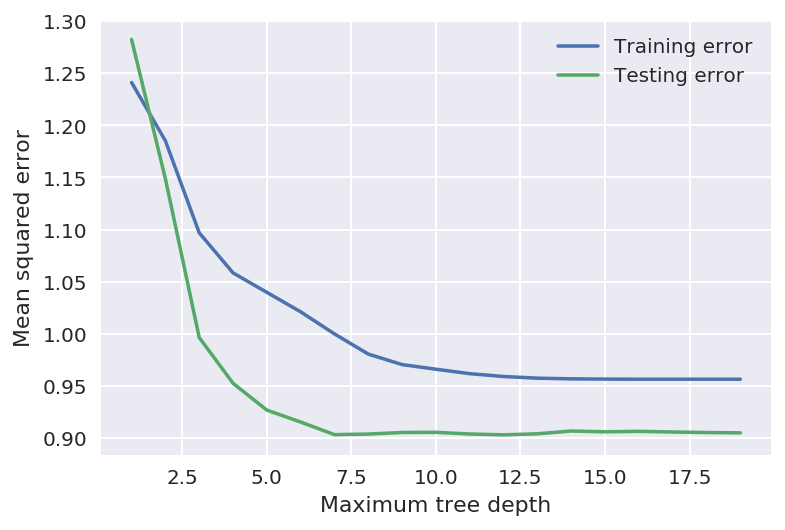

In [10]:
testing_error = []
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    testing_error.append(mse(y_test, model.predict(X_test)))

plt.plot(max_depths, training_error, label='Training error')
plt.plot(max_depths, testing_error, label='Testing error')
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean squared error')
plt.legend();

The testing error confirms our suspicion. As the model becomes more complex, it improves up to a point, and then it loses generalizability. One way to track complexity is the number of _parameters_ in our model. If we labeled each layer of our tree (starting with 0), we see there are $2^i$ parameters on layer $i$. Therefore the total number of parameters is $\sum_i 2**i$

Test set error has a global minimum internal to the domain boundary! (here, about 7)

In [11]:
list(zip(max_depths, [sum([2**i for i in range(max_depth)]) for max_depth in max_depths]))

[(1, 1),
 (2, 3),
 (3, 7),
 (4, 15),
 (5, 31),
 (6, 63),
 (7, 127),
 (8, 255),
 (9, 511),
 (10, 1023),
 (11, 2047),
 (12, 4095),
 (13, 8191),
 (14, 16383),
 (15, 32767),
 (16, 65535),
 (17, 131071),
 (18, 262143),
 (19, 524287)]

If we have enough parameters, we can simply memorize our training set, by creating a complex logical tree that separates all the different $X$ values in our training into unique branches of our tree. But _memorization is not learning_.

## Hyperparameters: tuning and cross-validation

When we defined our decision tree estimator, we chose how many layers the tree would have using the `max_depth` keyword. When we initiate an estimator, we can pass keyword arguments that will dictate its structure. The decision tree regressor accepts [12 different keyword arguments](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor). These arguments are called _hyperparameters_. This is in contrast to _parameters_, which are the numbers that our model uses to predict labels based on features. _Parameters_ are optimized during training. _Hyperparameters_ are decided before training and dictate the model's structure. Basically all models have hyperparameters. Even a simple linear regressor has a hyperparameter `fit_intercept`.

Since changing hyperparameters changes the structure of the model, we should think of choosing hyperparameters as part of model selection. `Scikit-learn` provides a useful tool for comparing different hyperparameter values, `GridSearchCV`. There are two ideas behind `GridSearchCV`: first we will split up the data into a training and validation set (using a method called [k-folds](http://scikit-learn.org/stable/modules/cross_validation.html#k-fold)) and then we train and evaluate models with different hyperparameters selected from a grid of combinations.

In [19]:
from sklearn.model_selection import GridSearchCV # also an 'estimator' with fit method etc

model = tree.DecisionTreeRegressor() # initiate object

gs = GridSearchCV(model, # pass model and dictionary of hyperparameter ranges
                  {'max_depth': range(1, 15),
                  'min_samples_split': range(10, 110, 10)},
                  cv=5,
                  n_jobs=2,
                  scoring='neg_mean_squared_error',
                  verbose=1) # outputs process

gs.fit(X_train, y_train) # tries all hyper combos - here, 15*11* 5 folds

print(gs.best_params_) # takes a min! - stored attribute best_params_

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 330 tasks      | elapsed:    5.3s


{'max_depth': 9, 'min_samples_split': 90}


[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:   10.8s finished


In [ ]:
model = gs.best_estimator_ # this attribute stores best hyperparameterised model
model.fit(X_train, y_train)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), model.predict(cali_df['Longitude'].sort_values().to_frame()), 'r-', label='model')
plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.legend()

print(mse(y_test, model.predict(X_test)))

## Comparing different estimators

`Scikit-learn`'s `GridSearchCV` only takes one estimator, so while it is useful for hyperparameter tuning, we can't use it to compare different estimators. However, we could easily iterate over different estimators, tune their hyperparameters using `GridSearchCV`, and use a metric to compare their performance.

For example, K-Neighbors is a very flexible model that uses the k-nearest points in feature space to predict the value of a new observation. Will this perform better than our decision tree?

In [23]:
from sklearn.neighbors import KNeighborsRegressor

tree_reg = tree.DecisionTreeRegressor()
knn_reg = KNeighborsRegressor()

estimators = {'tree_reg': tree_reg, 'knn_reg': knn_reg}
hyperparam_dict = {'tree_reg': {'min_samples_split': range(10, 110, 10), 'max_depth': range(1, 15)}, 'knn_reg': {'n_neighbors': range(10, 100, 10)}}
# dictionary of dictionaries, split by 'name'

scores = {}
for name, estimator in estimators.items():
    gs = GridSearchCV(estimator,
                      hyperparam_dict[name],
                      cv=5,
                      n_jobs=2,
                      scoring='neg_mean_squared_error',
                      verbose=1)
    
    gs.fit(X_train, y_train)

    scores[name] = -gs.best_score_

print(scores)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 556 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    8.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'tree_reg': 0.9386361108241427, 'knn_reg': 0.92735077508415}


[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    1.5s finished


### Question:
- K-Neighbors performed better than our decision tree; why might we pick decision tree even though it performs worse?

- Lower computational cost / quicker prediction speeds
- Higher interpretability / visualisation power
- Prediction power not all we are after

# Imputation (handling missing values)

Usually first transformation!
- Could throw away, but bad if truncating dataset by half...
- 

In [28]:
import pandas as pd
import numpy as np

In [29]:
df = pd.read_csv('data/titanic.csv')

FileNotFoundError: [Errno 2] File b'data/titanic.csv' does not exist: b'data/titanic.csv'

In [ ]:
df.isnull().sum() # age has many missing values

Can be good to impute mean or median or mode!

In [31]:
from sklearn.preprocessing import Imputer

In [34]:
Imputer?

In [ ]:
X = df['Age'].values

In [35]:
imp = Imputer(strategy = "mean")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
Xt = imp.fit_transform(X.reshape(-1, 1))

Median may be preferable since it is less variant to outliers. Could use GridSearchCV to see which of mean or median yields lower CV error!

# Categorical Data

In [ ]:
from sklearn.preprocessing import LabelEncoder # transformer, with standard methods fit_transform

LabelEncoder?

In [ ]:
encoder = LabelEncoder()
Xt = encoder.fit_transform(embarked) # for example

But ordering of numerical values may not make sense in context of data eg 2*S \= Q. Can use one hot encoder! Like Statistical Methods III. Uses sparse matrices.

In [ ]:
from sklearn.preprocessing import OneHotEncoder # transformer, with standard methods fit_transform

OneHotEncoder?

In [ ]:
one_hot = OneHotEncoder()
Xtt = one_hot.fit_transform(Xt.reshape(-1, 2))

# GridSearchCV and Pipelines 1

Both Gridsearch and Pipelines are estimators!

In [46]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [48]:
X = fetch_california_housing()['data']
y = fetch_california_housing()['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [51]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())])
pipe.fit(X_train, y_train)
        
print(pipe.score(X_test, y_test))

0.5943141338604155


In [53]:
pipe.get_params() # fitted pipelines absorb parameters and store as 'name__param', so use these when tuning

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('regressor',
   Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
         normalize=False, random_state=None, solver='auto', tol=0.001))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'regressor': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'regressor__alpha': 1.0,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__max_iter': None,
 'regressor__normalize': False,
 'regressor__random_state': None,
 'regressor__solver': 'auto',
 'regressor__tol': 0.001}

In [56]:
param_grid = {'regressor__alpha': np.logspace(-3, 3, 20)}

In [58]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regressor',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=2,
             param_grid={'regressor__al...3240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.359818

In [60]:
grid_search.best_params_ # notice name!

{'regressor__alpha': 12.742749857031322}

In [61]:
grid_search.best_score_

0.6053956962874548

Any downsides to this method? When call fit method of Gridsearch, it fits a lot of training processes (refit standard scaler then refit Ridge etc for all estimators upstream). But we are only tuning hyperparam for final step.

In [63]:
from tempfile import mkdtemp
from shutil import rmtree

cachedir = mkdtemp() # creates a temp. directory
pipe_cache = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())], memory=cachedir)
# done the fitting, so saving estimators to disk to load cached file later

pipe_cache.fit(X_train, y_train)

Pipeline(memory='/tmp/tmp9z8majxo',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regressor',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [64]:
rmtree(cachedir) # customary to then delete from memory

## Method 2

What if in pipeline a Gridsearch object instead of Ridge?

Another solution - since want to conduct Gridsearch only on the predictor step (here, Ridge). This means it cannot tune hyperparameters for transformations upstream in the pipeline. We have a Ridge GridSearch **step** in the pipeline.

In [72]:
param_grid = {'alpha': np.logspace(-3, 3, 20)}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, n_jobs=2, verbose=1)

pipe_2 = Pipeline([('scalar', StandardScaler()), ('grid_search', grid_search)])
pipe_2.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished


Pipeline(memory=None,
         steps=[('scalar',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('grid_search',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001),
                              iid='warn', n_jobs=2,
                              param_grid={'alpha': array([1.00000000e-03...90e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},


In [74]:
pipe_2.named_steps['grid_search'] # inspect grid search step of pipeline

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=2,
             param_grid={'alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [75]:
pipe_2.named_steps['grid_search'].best_params_

{'alpha': 26.366508987303554}

What if we had a DR step before Ridge prediction and we weanted to tune PCA hyperparams? Back to **Method 1** where we cache the pipeline and conduct GridSearch only on **"step__param"** of interest (in the param grid).

In [76]:
from sklearn.decomposition import PCA

cachedir = mkdtemp()
pipe_3 = Pipeline([('scaler', StandardScaler()),
                   ('dim_red', PCA()),
                   ('regressor', Ridge())], memory=cachedir)

param_grid = {'dim_red__n_components': [2, 3, 4, 5, 6],
              'regressor__alpha': np.logspace(-3, 3, 20)}

grid_search = GridSearchCV(pipe_3, param_grid, cv=5, n_jobs=2, verbose=1)
grid_search.fit(X_train, y_train)



rmtree(cachedir)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 202 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    9.5s finished


In [77]:
grid_search.best_params_ # best tuned params for PCA and Ridge steps!

{'dim_red__n_components': 6, 'regressor__alpha': 26.366508987303554}

# RandomisedSearchCV

Samples only part of the grid space - only slightly worse for far improved run times.

In [79]:
from sklearn.model_selection import RandomizedSearchCV

RandomizedSearchCV?
# "Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.""

In [80]:
cachedir = mkdtemp()
pipe_4 = Pipeline([('scaler', StandardScaler()),
                   ('dim_red', PCA()),
                   ('regressor', Ridge())], memory=cachedir)

param_grid = {'dim_red__n_components': range(1, 9),
              'regressor__alpha': np.logspace(-3, 3, 200)}

random_search = RandomizedSearchCV(pipe_4, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=100)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 104 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    8.7s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory='/tmp/tmp06pln06y',
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('dim_red',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('regressor',
                                              Ridge(alpha=1.0,

In [82]:
print(random_search.score(X_test, y_test))
rmtree(cachedir)

0.5941548046996843
